# Workshop 5. Unsupervised Classification of Multiband Imagery with K-Means  

**Students:** María Fernanda López 🦄
                Megan García Antivar 🦄
                
**Course:** Geoprocesamiento, Universidad Nacional de Colombia  

**Reference:** *Data Science – Unsupervised Classification of Satellite Images with K-Means Algorithm* 

## 🗺️ Descripción general

Este cuaderno demuestra una clasificación de cobertura terrestre no supervisada utilizando el algoritmo K-Means. El flujo de trabajo sigue el tutorial en línea [Disponible aquí](https://ml-gis-service.com/index.php/2020/10/14/data-science-unsupervised-classification-of-satellite-images-with-k-means-algorithm/), adaptado a un único GeoTIFF multibanda recortado (700 × 700 px).

**Etapas clave**

1. Importar las bibliotecas necesarias y crear un subconjunto recortado.
2. Mostrar una vista previa RGB en color natural.
3. Reestructurar el subconjunto en una matriz de características bidimensional.
4. Construir y entrenar `ClusteredStack`, una clase que encapsula el flujo de trabajo de K-Means.
5. Inspeccionar los mapas clasificados, la inercia (método del codo) y las puntuaciones de silueta.
6. Guardar el mapa óptimo como un nuevo ráster.

## 1. Importar librerías

In [44]:
import os
import shutil

# Standard and scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from rasterstats import point_query
import rasterio.windows as rwin
import geopandas as gpd
import rsgislib
import rsgislib.imageutils
import rsgislib.vectorutils

# Machine-learning tools
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Image-enhancement for visual interpretation
from skimage.exposure import equalize_adapthist

## 2. Cargar los conjuntos de datos y generar un subconjunto de trabajo

La escena original es considerablemente más grande de lo necesario para este tutorial.
Para acelerar el procesamiento, recortamos una ventana **centrada de 700 × 470 píxeles** y la guardamos como un nuevo archivo GeoTIFF. Los pasos ejecutados en la siguiente celda de código son:

1. **Abrir** el ráster completo y obtener su ancho y alto totales.
2. **Definir** un objeto `Window` cuya origen (`col_off`, `row_off`) se elige de forma que la ventana quede centrada en la escena.
3. **Leer** solo los píxeles dentro de esa ventana, generando así un arreglo multibanda mucho más pequeño.
4. **Clonar** los metadatos originales y actualizar el alto, ancho y la transformación afín para que el subconjunto permanezca correctamente georreferenciado.
5. Escribir el subconjunto en disco con compresión LZW y tiling habilitado, produciendo el archivo `mi_stack_subset_400.tif`.

A partir de este punto, el cuaderno utiliza el subconjunto liviano, reduciendo considerablemente el consumo de memoria y el tiempo de ejecución.

| Variable | Significado                                                                                                                                        | Por qué la necesitamos                                                                                          |
| -------- | -------------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------- |
| `H`, `W` | Altura y ancho total (en píxeles) de la escena original.                                                                                           | Se usan para calcular los desplazamientos que centran la ventana del subconjunto.                               |
| `win`    | Objeto `rasterio.windows.Window`.                                                                                                                  | Especifica las filas/columnas exactas (origen + tamaño) a extraer.                                              |
| `subset` | Arreglo de NumPy que contiene los valores de píxeles de todas las bandas dentro de la ventana.                                                     | Se convierte en la imagen en memoria que luego se guarda en disco.                                              |
| `meta`   | Diccionario copiado de los metadatos del ráster original, luego modificado para la imagen más pequeña (nueva altura, ancho y transformación afín). | Garantiza que el subconjunto herede el sistema de referencia, datum y geotransformación correctos al guardarse. |


In [2]:
m_root=r'/notebooks/Geoprocesamiento/Workshop/data/Workshop_3/'
raster_path = m_root+r'sentinel2_2018_epsg3116.tif'# Path to the original image

In [3]:
#Path to an image subset (as the original one is too large)
subset_path = m_root+r'subset_700.tif'
rows, cols  = 1400, 1400                             # subset size

with rio.open(raster_path) as src:
    H, W = src.height, src.width
    win  = rwin.Window((W - cols)//2, (H - rows)//2, cols, rows)
    subset = src.read(window=win)
    meta   = src.meta.copy()
    meta.update({"height": rows,
                 "width":  cols,
                 "transform": src.window_transform(win),
                 "compress": "lzw",
                 "tiled": True})

with rio.open(subset_path, "w", **meta) as dst:
    dst.write(subset)

print("Subset written in →", subset_path)

# --- Print key metadata fields to understand what is stored ---
print("Subset metadata summary:")
print(f"  Dimensions    → {meta['width']} × {meta['height']} px")
print(f"  Band count    → {meta['count']} bands")
print(f"  CRS           → {meta['crs']}")
print(f"  Data type     → {meta['dtype']}")
print(f"  Transform     →\n    {meta['transform']}")

Subset written in → /notebooks/Geoprocesamiento/Workshop/data/Workshop_3/subset_700.tif
Subset metadata summary:
  Dimensions    → 700 × 700 px
  Band count    → 10 bands
  CRS           → EPSG:3116
  Data type     → float64
  Transform     →
    | 9.98, 0.00, 962967.34|
| 0.00,-9.98, 577518.55|
| 0.00, 0.00, 1.00|


## 3. Vista previa del subconjunto en color natural

Las imágenes satelitales suelen contener valores extremos de píxel causados por nubes, sombras o superficies muy brillantes.
Por esta razón, aplicamos un suave estiramiento lineal del 1 al 99 % por banda, además de una corrección gamma moderada para obtener una imagen visualmente equilibrada. Esto significa:

- El 1 % más oscuro de los valores de píxel se mapea a 0 (negro),
- El 1 % más brillante se mapea a 1 (blanco),
- El 98 % restante se estira linealmente a lo largo del rango completo de visualización de 0 a 1.

Esta técnica mejora el contraste ignorando los valores atípicos, lo que facilita distinguir las características sin distorsionar la apariencia general.

Cada banda (Rojo, Verde, Azul) se estira de forma **independiente** utilizando su propio rango del 1–99 %, asegurando que se conserve el balance de color y el contraste.

La **corrección gamma** ajusta el brillo de los tonos medios sin alterar drásticamente los píxeles más oscuros o más brillantes. Se aplica *después* del estiramiento y ayuda a afinar la apariencia de la imagen para una mejor interpretación visual.

La fórmula de corrección gamma se define como:

$$
\text{output\_pixel} = (\text{input\_pixel})^\gamma
$$

Donde:

- $\text{input\_pixel}$ es el valor de píxel normalizado (entre 0 y 1),  
- $\gamma$ es el coeficiente gamma,  
- $\text{output\_pixel}$ es el valor de brillo ajustado.  

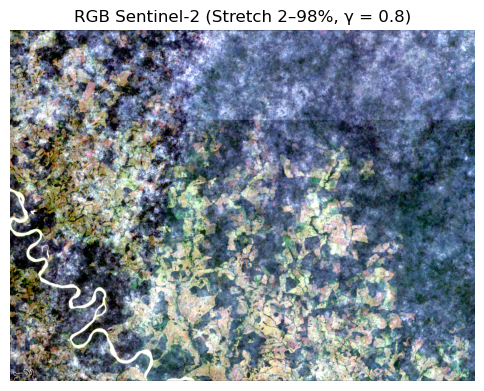

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# B4-B3-B2 en tu orden
bands_rgb = [2, 1, 0]
gamma = 0.8  # brillo medio más suave

channels = []
for b in bands_rgb:
    band = img[b].astype(float)
    band = np.nan_to_num(band)

    # Estiramiento con percentil 2–98 (más conservador que 1–99)
    lo, hi = np.percentile(band, (2, 98))
    band = np.clip((band - lo) / (hi - lo), 0, 1)

    channels.append(band)

# Apilar y aplicar corrección gamma
rgb = np.dstack(channels) ** gamma

# Visualizar
plt.figure(figsize=(6, 6))
plt.imshow(rgb)
plt.title("RGB Sentinel-2 (Stretch 2–98%, γ = 0.8)")
plt.axis("off")
plt.show()

### 3.1 Scatter plot

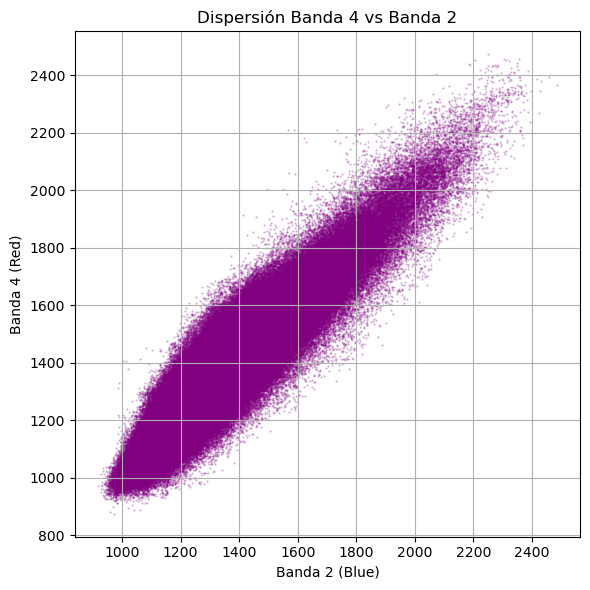

In [5]:
# Abrir la imagen con rasterio
with rio.open(subset_path) as src:
    
    banda2 = src.read(2).astype(float)  # Red
    banda4 = src.read(4).astype(float)  # NIR

x = banda2.flatten()
y = banda4.flatten()

# Opcional: enmascarar valores nulos o cero
mascara = (x > 0) & (y > 0)
x = x[mascara]
y = y[mascara]

# Crear scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(x, y, s=0.3, alpha=0.3, c='purple')
plt.xlabel('Banda 2 (Blue)')
plt.ylabel('Banda 4 (Red)')
plt.title('Dispersión Banda 4 vs Banda 2')
plt.grid(True)
plt.tight_layout()
plt.show()

## 4 · The `ClusteredStack` class  

Esta clase encapsula todo el flujo de trabajo de clasificación no supervisada.

#### `__init__(self, raster_path)` Inicializa la instancia de la clase.

#### `set_raster_stack(self)`
Lee el ráster y lo reorganiza en un formato adecuado para K-Means.

- Lee toda la pila: forma (bandas, filas, columnas).
- Reemplaza los valores NaN por 0 para evitar problemas durante el entrenamiento.
- Convierte el arreglo 3D en una matriz 2D con forma (n_pixeles, n_bandas)
  — este es el formato de entrada requerido por scikit-learn.
- Guarda las dimensiones de la imagen para reorganizar posteriormente la salida de la clasificación.

---

#### `build_models(self, k_values)`
Entrena un modelo K-Means por cada valor de *k* en la lista proporcionada.

- Para cada *k*:

  - Crea y ajusta un modelo `KMeans` usando los datos reorganizados.
  - Almacena el objeto del modelo y las etiquetas predichas.
  - Calcula la **inercia** (suma de las distancias cuadradas dentro de los clústeres).
  - Calcula el **puntaje de silueta**, que mide la separación entre clústeres.
- Reorganiza las etiquetas predichas (planas) nuevamente a forma de imagen (filas × columnas).
- Guarda cada ráster clasificado en una lista para su posterior visualización.

---

#### `show_clustered(self, cmap="Accent")` 
Muestra todos los mapas clasificados correspondientes a cada *k*.

- Cada imagen se muestra en una gráfica separada con un mapa de colores categórico.
- La barra de color ayuda a interpretar las etiquetas numéricas de los clústeres.
- Permite inspeccionar visualmente los patrones espaciales producidos por cada k.

---

#### `show_inertia(self)`
Grafica la curva del método del codo (Elbow).

- Se grafica la puntuación de *inercia* contra *k*.
- Ayuda a identificar el punto donde agregar más clústeres produce beneficios decrecientes
  — el "codo".
- Una inercia más baja indica clústeres más compactos.

---

#### `show_silhouette(self)`
Grafica el puntaje de silueta para cada *k*.

- El **puntaje de silueta** varía de –1 a 1:
    - Un puntaje alto (≈ 1) indica clústeres densos y bien separados.
    - Un puntaje bajo o negativo sugiere clústeres superpuestos o mal definidos.
- Esta métrica complementa el método del codo al revelar la calidad de la separación entre clústeres.



In [6]:
# %% Listings 5-7 completos (adaptados)
class ClusteredStack:
    
    def __init__(self, raster_path): # Initialises the class instance.
        self.raster_path = raster_path # path to the multiband GeoTIFF (e.g., the 400×400 subset).  
        self.model_input = None #    the reshaped data matrix  
        self.height = self.width = self.depth = 0 # image dimensions
        self.k_range = [] # List of all k-values (number of clusters) to evaluate
        self.models = [] # Trained KMeans models for each k; stored for later inspection
        self.predicted_rasters = [] # Cluster label images (reshaped to raster size)
        self.inertia_scores = [] # Inertia values (sum of squared distances within clusters); used for Elbow method
        self.silhouette_scores = [] # Silhouette scores (measure of cluster separation); used for model selection

    
    def set_raster_stack(self):
        """Reads the raster and reshapes it into a format suitable for K-Means."""
        with rio.open(self.raster_path) as src:

            # Read all bands into a 3D NumPy array of shape (bands, rows, cols)
            stack = src.read()

             # Replace any NaN (Not-a-Number) values with zero. Avoids errors during clustering algorithms, which cannot handle NaNs
            stack = np.nan_to_num(stack)   
        # Extract the number of bands, rows, and columns from the raster's shape
        # These values are stored as object attributes for later use
        self.depth, self.height, self.width = stack.shape

        # Reshape the 3D array into a 2D matrix of shape (n_pixels, n_bands)
        # Each row now corresponds to one pixel, and each column to a spectral band
        # Transposition (.T) ensures the matrix has the correct shape for scikit-learn
        self.model_input = stack.reshape(self.depth, -1).T


    def build_models(self, k_values):
        """
            Trains one K-Means clustering model for each value of k provided in k_values.
         It stores the resulting models, cluster labels, and evaluation metrics.
        """

        # Convert the input iterable into a list and store it
        # This list defines the number of clusters to be tested (e.g. [3, 4, 5, ..., 10])
        self.k_range = list(k_values)

        # Initialise empty lists to store models, results, and metrics
        self.models, self.predicted_rasters = [], [] # Trained KMeans objects  - Cluster label images (reshaped to raster form)
        self.inertia_scores, self.silhouette_scores = [], [] # Inertia values for each k - # Silhouette scores for each k

        for k in self.k_range:

            # Create a KMeans model with k clusters
            # random_state ensures reproducibility; n_init specifies how many times the algorithm will run with different centroid seeds
            km = KMeans(n_clusters=k, random_state=42, n_init=10)

             # Fit the model to the reshaped raster and predict the cluster labels
             # This returns one label (cluster ID) per pixel
            labels = km.fit_predict(self.model_input)

            # Store the trained model
            self.models.append(km)

            # Record the inertia for this k (lower is better; used in Elbow method)
            self.inertia_scores.append(km.inertia_)

            # Calculate and store the silhouette score for this k
            # A higher silhouette score indicates better-defined clusters
            # Sampling is limited to 1000 points for performance reasons
            self.silhouette_scores.append(
                silhouette_score(self.model_input, labels, sample_size=1000)
            )

            # Reshape the flat list of labels back to image form (rows × cols)
            # This is required for visualising the classified image later
            self.predicted_rasters.append(labels.reshape(self.height, self.width))


    def show_clustered(self, cmap="Accent"):
        """
        Displays one classified raster image for each value of k.
        Each image uses a categorical colourmap for easy interpretation.
        """
        for k, img_cls in zip(self.k_range, self.predicted_rasters):
            plt.figure(figsize=(5, 5))
            plt.imshow(img_cls, cmap=cmap)
            plt.title(f"{k} clusters")
            plt.axis("off")
            plt.colorbar()
            plt.show()

    def show_inertia(self):
        """
        Plots the inertia values for each k to apply the Elbow method.
        Inertia measures how tightly the data points are clustered around their centroids.
        Lower values indicate more compact clusters.
        """
        plt.figure(figsize=(5, 4))
        plt.plot(self.k_range, self.inertia_scores, "o-")
        plt.xlabel("Number of clusters (k)")
        plt.ylabel("Inertia")
        plt.title("Elbow method")
        plt.show()

    def show_silhouette(self):
        """
        Plots the silhouette scores for each k to assess clustering quality.
        Silhouette score ranges from -1 to 1, with higher values indicating
        better-defined, well-separated clusters.
        """
        plt.figure(figsize=(5, 4))
        plt.plot(self.k_range, self.silhouette_scores, "o-")
        plt.xlabel("Número de clusters (k)")
        plt.ylabel("Silhouette Coeff.s")
        plt.title("Silhouette scores")
        plt.show()

El siguiente bloque de código lee una única imagen ráster multibanda, reemplaza cualquier valor `NoData` o `NaN` por 0 y reestructura el arreglo de manera que cada fila represente un píxel y cada columna una banda espectral.

1. Abre el ráster utilizando `rasterio` dentro de un bloque `with`, lo que garantiza que el archivo se cierre correctamente después (manejo seguro de recursos).
2. Lee todas las bandas a la vez, lo que da como resultado una `pila` 3D con forma `(bandas, filas, columnas)`.
3. Reemplaza cualquier valor faltante o indefinido (`NaN`) por `0` utilizando `np.nan_to_num()`.
4. Almacena el número de bandas (`profundidad`), filas (`altura`) y columnas (`ancho`) como atributos de la clase para usarlos en pasos posteriores.
5. Reestructura la pila 3D en una matriz 2D usando `.reshape().T`, lo que produce un arreglo con forma `(n_pixeles, n_bandas)` — el formato de entrada requerido por algoritmos de scikit-learn como K-Means.

🔄 Este método reemplaza al *Listing 5: `ClusteredBands` – set bands stack method* del tutorial de K-Means.

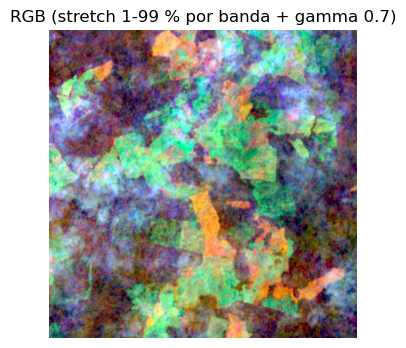

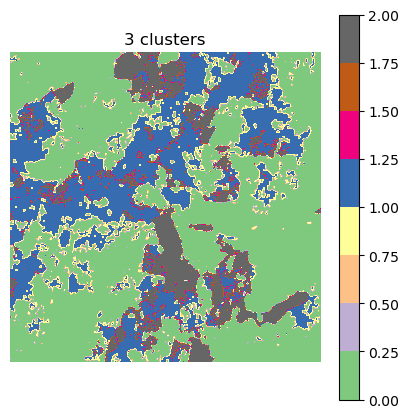

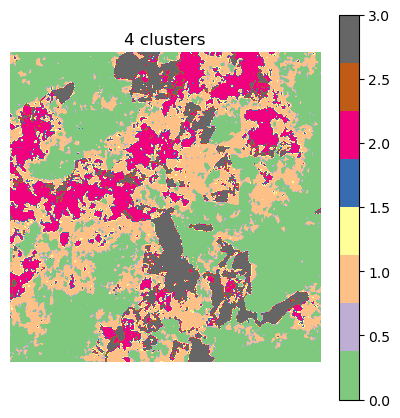

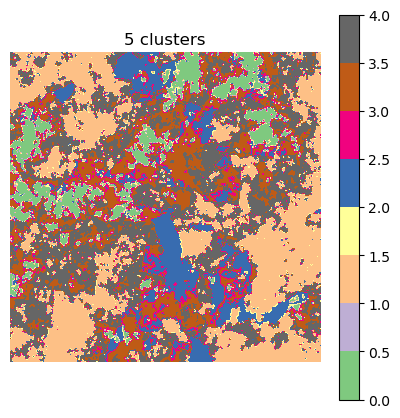

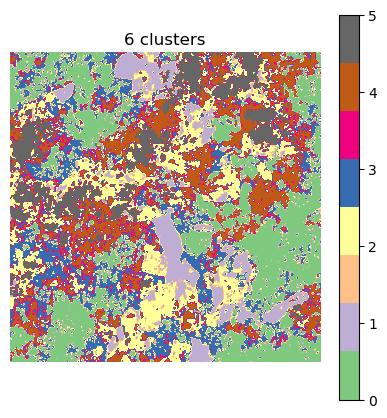

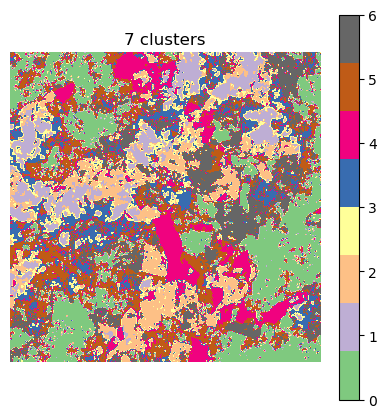

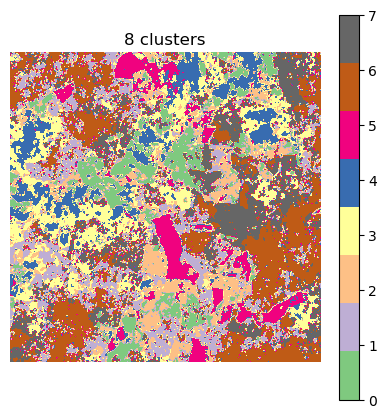

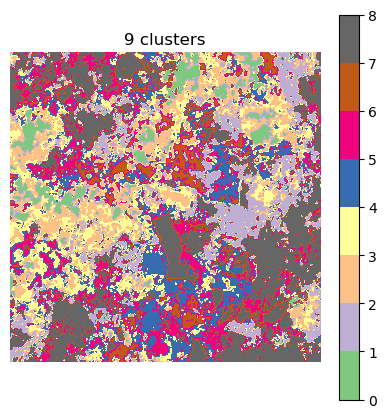

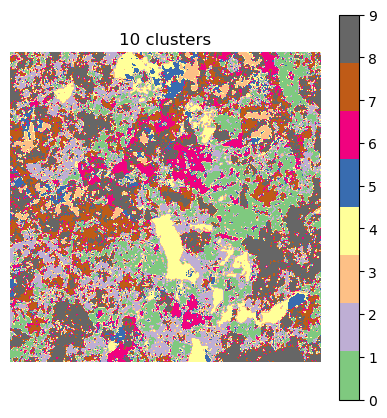

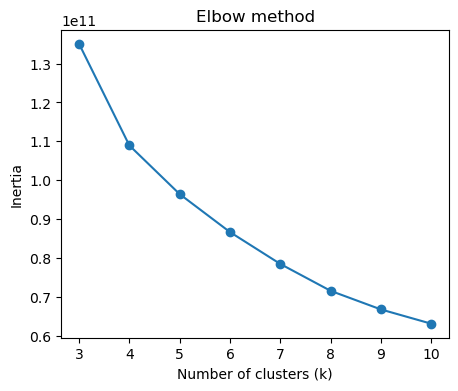

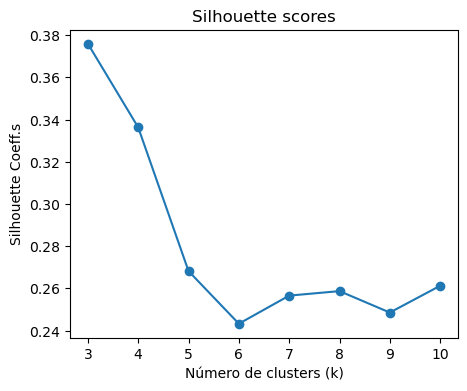

In [7]:
# ==== Model training and visualisation (tutorial-style layout) ====

# 1. Instantiate the object
# This creates an instance of the ClusteredStack class using the clipped raster
clustered_models = ClusteredStack(subset_path)

# Load the raster and reshape it into a 2D array of pixels × bands
clustered_models.set_raster_stack()

# 2. Define the range of k values (number of clusters to evaluate)
# Equivalent to testing k = 3, 4, ..., 10
ranges = np.arange(3, 11, 1)

# 3. Train the models
# For each k, this will:
# - Fit a KMeans model
# - Store the predicted labels
# - Compute inertia and silhouette scores
clustered_models.build_models(ranges)

# 4. Display the RGB preview again
# This step is optional but helps visually link the original image with the results
with rio.open(subset_path) as src:
    rgb_preview = src.read()                 # (bands, rows, cols)

plt.figure(figsize=(4,4))
plt.imshow(rgb)
plt.title("RGB (stretch 1-99 % por banda + gamma 0.7)")
plt.axis("off")
plt.show()

clustered_models.show_clustered()
clustered_models.show_inertia()

# --- Alias para mantener el nombre del tutorial ---
ClusteredStack.show_silhouette_scores = ClusteredStack.show_silhouette
clustered_models.show_silhouette_scores()

### Selección del área de estudio

Al igual que en el ejercicio de clasificación supervisada con el algoritmo de Random Forest se elige un polígono de la zona de Amazonas. Por tanto, se carga la clasificación supervisada realizada en el ejercicio anterior para poder sumar la otra variable.

Image Data Size: 4360 x 3288


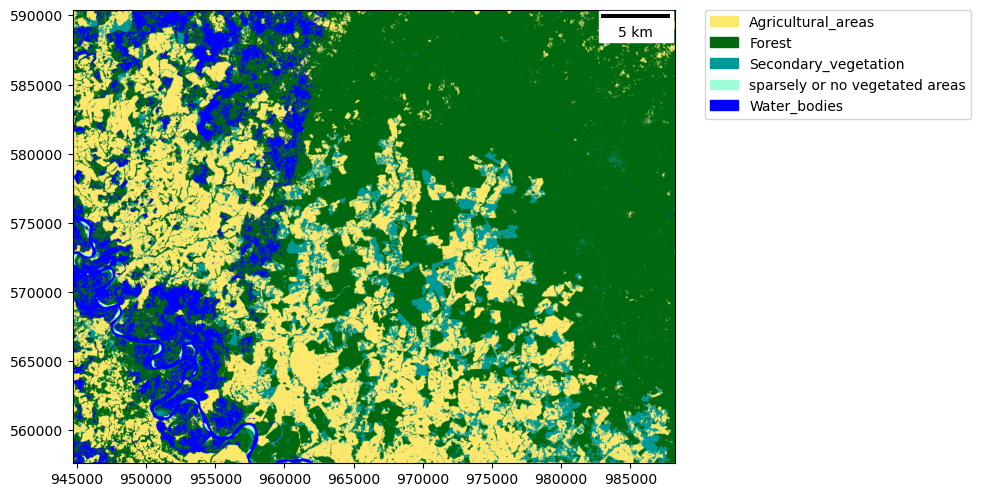

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import rsgislib.tools.mapping

# Diccionario de clases y colores RGB (ejemplo)
class_labels = {
    "Agricultural_areas": (252, 232, 109),
    "Forest": (0, 105, 16),
    "Secondary_vegetation": (0, 153, 153),
    "sparsely or no vegetated areas": (156, 255, 215),
    "Water_bodies": (0, 0, 255)
}

# Convertir los colores RGB (0–255) a formato 0–1
def rgb_to_mpl(rgb):
    return tuple([v/255 for v in rgb])

# Crear figura
fig, ax = plt.subplots(figsize=(10, 10))

# Mapa clasificado
rsgislib.tools.mapping.create_thematic_raster_map(
    ax=ax,
    input_img="clasificacion_rf_2018.kea"
)

# Crear leyenda personalizada
legend_patches = [
    mpatches.Patch(color=rgb_to_mpl(rgb), label=label)
    for label, rgb in class_labels.items()
]

# Añadir leyenda fuera del mapa
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

### Elegir el mejor resultado de la clasificación no supervisada

Al evaluar los valores de inercia (`método del codo`), observamos una fuerte disminución hasta k = **4**, luego el cambio marginal se reduce. Esto sugiere que agregar más clústeres a partir de este punto aporta poco a la compactación interna de los grupos.

Adicionalmente, el `coeficiente de silueta` alcanza un valor relativamente alto en k = 4, lo que indica una buena separación entre clústeres sin superposición significativa. Aunque k = 3 tenía una silueta ligeramente más alta, la segmentación espacial con k = 4 mostró mejor distinción entre clases visuales relevantes (vegetación, cuerpos de agua, suelo desnudo, etc.).

> En la segmentación espacial para `k = 4`, se identifican claramente zonas diferenciadas:

> * Un clúster se asocia con vegetación densa (alta reflectancia en NIR),
> * Otro con zonas agrícolas o pastos (transiciones de rojo y verde),
> * Uno más corresponde a superficies sin vegetación o áreas degradadas,
> * Y un último agrupa cuerpos de agua o sombras densas.

La distribución espacial de los clústeres refleja patrones de uso del suelo evidentes en la imagen RGB, y puede ser usada como insumo para análisis multiclase o preclasificación supervisada.

In [ ]:
plt.imshow(clustered_models.predicted_rasters[clustered_models.k_range.index(4)], cmap="tab10")
plt.title("K-Means clustering (k = 4)")
plt.axis("off")
plt.colorbar()
plt.show()

### Agregar la clasificación no supervisada como covariable

#### Extraer y añadir k-means a la imagen satelital

Primero se extrae el mapa de clústeres `k=4` y en formato kea.

In [ ]:
k = 4
cluster_img = clustered_models.predicted_rasters[clustered_models.k_range.index(k)]

Leer la imagen satelital base para obtener metadatos.

In [ ]:
with rio.open(subset_path) as src:
    profile = src.profile.copy()
    img_data = src.read()  # shape: (bands, rows, cols)

Verificar que cluster_img tenga las mismas dimensiones espaciales.

In [ ]:
print("Satelital shape:", img_data.shape[1:], "| Clusters shape:", cluster_img.shape)

Crear imagen compuesta con la banda extra.

In [ ]:
# Expandimos la dimensión para que sea 3D (1, rows, cols)
cluster_band = np.expand_dims(cluster_img, axis=0)

# Concatenamos la banda nueva (cluster) al final
stacked_img = np.concatenate((img_data, cluster_band), axis=0)  # shape: (bands+1, rows, cols)

Actualizar metadatos para escribir la nueva imagen

In [ ]:
profile.update({
    "count": stacked_img.shape[0],
    "dtype": 'uint8'
})

Guardar la nueva imagen con la banda del cluster añadida.

In [ ]:
out_path = "satelital_con_kmeans_k4.tif"

with rio.open(out_path, "w", **profile) as dst:
    dst.write(stacked_img.astype("uint8"))

#### Correr clasificador de random forest con k-means como covariable

In [ ]:
input_image = "satelital_con_kmeans_k4.tif"

img_band_info = list()
img_band_info.append(
    rsgislib.imageutils.ImageBandInfo(
        file_name=input_img, name="sen2", bands=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    )
)
print(img_band_info)

In [46]:
vec_train_file = "data/Workshop_3/Training_data_epsg3116.gpkg"

class_vec_sample_info = list()

# Define the file name of the samples HDF5 file, which will be created
agricultural_areas_h5 = "agricultural_areas_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=1,
        class_name="Agricultural_areas",
        vec_file=vec_train_file,
        vec_lyr="Agricultural_areas",
        file_h5=agricultural_areas_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
forest_h5 = "forest_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=2,
        class_name="Forest",
        vec_file=vec_train_file,
        vec_lyr="Forest",
        file_h5=forest_h5,
    )
)


# Define the file name of the samples HDF5 file, which will be created
secondary_vegetation_h5 = "secondary_vegetation_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=3,
        class_name="Secondary_vegetation",
        vec_file=vec_train_file,
        vec_lyr="Secondary_vegetation",
        file_h5=secondary_vegetation_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
sparsely_no_veg_h5 = "sparsely_no_veg_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=4,
        class_name="sparsely or no vegetated areas",
        vec_file=vec_train_file,
        vec_lyr="sparsely_or_no_vegetated_areas",
        file_h5=sparsely_no_veg_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
water_bodies_h5 = "water_bodies_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=5,
        class_name="Water_bodies",
        vec_file=vec_train_file,
        vec_lyr="water_bodies",
        file_h5=water_bodies_h5,
    )
)

## See what is inside  class_vec_sample_info
print(class_vec_sample_info)

[<rsgislib.classification.ClassVecSamplesInfoObj object at 0x77939d935690>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x7793883e15d0>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x77939da5c290>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x77939da3dbd0>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x77939da3f790>]


In [ ]:
obj = class_vec_sample_info[0]
vars(obj)        # returns a dictionary of attributes
# or
obj.__dict__

In [ ]:
tmp_dir = "./tmp"

if not os.path.exists(tmp_dir):
    os.mkdir(tmp_dir)

In [ ]:
cls_smpls_info = rsgislib.classification.get_class_training_data(
    img_band_info, class_vec_sample_info, tmp_dir, ref_img=in_msk_img
)

In [ ]:
# Output the returned class samples info object 
cls_smpls_info

In [ ]:
cls_smpls_info["Agricultural_areas"].red = 252
cls_smpls_info["Agricultural_areas"].green = 232
cls_smpls_info["Agricultural_areas"].blue = 109

cls_smpls_info["Forest"].red = 0
cls_smpls_info["Forest"].green = 105
cls_smpls_info["Forest"].blue = 16

cls_smpls_info["Secondary_vegetation"].red = 0
cls_smpls_info["Secondary_vegetation"].green = 153
cls_smpls_info["Secondary_vegetation"].blue = 153

cls_smpls_info["sparsely or no vegetated areas"].red = 156
cls_smpls_info["sparsely or no vegetated areas"].green = 255
cls_smpls_info["sparsely or no vegetated areas"].blue = 215

cls_smpls_info["Water_bodies"].red = 0
cls_smpls_info["Water_bodies"].green = 0
cls_smpls_info["Water_bodies"].blue = 255

cls_smpls_info

In [ ]:
for cls_name in cls_smpls_info:
    smpls_h5_file = cls_smpls_info[cls_name].file_h5
    n_smpls = rsgislib.classification.get_num_samples(smpls_h5_file)
    print(f"{cls_name}: {n_smpls}")

In [ ]:
# Run the create_train_valid_test_sets helper function to
# create the train, valid and test datasets
rsgislib.classification.create_train_valid_test_sets(
    cls_smpls_info, cls_smpls_fnl_info, 100, 100, 1000
)

In [ ]:
print("Muestras finales por clase (entrenamiento / validación / prueba):\n")

for clase, info in cls_smpls_fnl_info.items():
    n_train = rsgislib.classification.get_num_samples(info.train_file_h5)
    n_valid = rsgislib.classification.get_num_samples(info.valid_file_h5)
    n_test = rsgislib.classification.get_num_samples(info.test_file_h5)

    print(f"🔸 {clase}")
    print(f"   Entrenamiento : {n_train}")
    print(f"   Validación    : {n_valid}")
    print(f"   Prueba        : {n_test}\n")

In [ ]:
grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid={
        "n_estimators": [10, 20, 50, 100, 150, 200],
        "max_depth": [4, 8, 10, 12, 14, 16],
    },
)
print(grid_search )
sk_classifier = (
    rsgislib.classification.classsklearn.perform_sklearn_classifier_param_search(
        cls_smpls_fnl_info, grid_search
    )
)

In [ ]:
rsgislib.classification.classsklearn.train_sklearn_classifier(
    cls_smpls_fnl_info, sk_classifier
)

In [ ]:
from osgeo import gdal
from rsgislib.classification import ImageBandInfo
import rsgislib.classification.classsklearn

# Definir rutas
input_img = "data/Workshop_3/sentinel2_2018_epsg3116.tif"
in_msk_img = "data/Workshop_3/sentinel2_2018_vmask_3116.tif"
out_cls_img = "clasificacion_rf_2018_sup.kea"
out_scr_img = "clasificacion_rf_score_2018_sup.kea"

# Obtener número de bandas
ds = gdal.Open(input_img)
n_bands = ds.RasterCount

# Crear objeto ImageBandInfo
img_band_info = [ImageBandInfo(name="sen2", file_name=input_img, bands=[i+1 for i in range(n_bands)])]

# Aplicar clasificador
rsgislib.classification.classsklearn.apply_sklearn_classifier(
    cls_smpls_fnl_info,  # cls_info
    sk_classifier,       # cls_obj
    in_msk_img,          # in_msk_img
    1,                   # img_msk_val
    img_band_info,       # img_file_info
    out_cls_img,         # out_class_img
    "KEA",               # gdalformat
    True,                # class_clr_names
    out_scr_img          # out_score_img
)

#### Comparación de las dos clasificaciones

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import rsgislib
from rsgislib import tools

# === Diccionario de clases y colores RGB (0–255)
class_labels = {
    "Agricultural_areas": (252, 232, 109),
    "Forest": (0, 105, 16),
    "Secondary_vegetation": (0, 153, 153),
    "sparsely or no vegetated areas": (156, 255, 215),
    "Water_bodies": (0, 0, 255)
}

# Convertir RGB 255 → 0–1 (para matplotlib)
def rgb_to_mpl(rgb):
    return tuple([v/255 for v in rgb])

# Ruta de las dos imágenes a comparar
img_clasica = "clasificacion_rf_2018.kea"
img_con_kmeans = "clasificacion_rf_2018_sup.kea"

# Bounding box de la zona de análisis
sub_img_bbox = [944712.7306693317, 988204.5931766616, 557628.0093751058, 590426.4598164133]

# === Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Mapa clasificado tradicional
tools.mapping.create_thematic_raster_map(
    ax=ax1,
    input_img=img_clasica,
    bbox=sub_img_bbox
)
ax1.set_title("Clasificación tradicional")

# Mapa clasificado con covariable KMeans
tools.mapping.create_thematic_raster_map(
    ax=ax2,
    input_img=img_con_kmeans,
    bbox=sub_img_bbox
)
ax2.set_title("Clasificación + covariable KMeans")

# Crear parches de la leyenda (una sola para ambos mapas)
legend_patches = [
    mpatches.Patch(color=rgb_to_mpl(rgb), label=label)
    for label, rgb in class_labels.items()
]

# Añadir leyenda en el centro derecho
ax2.legend(
    handles=legend_patches,
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    title="Clases"
)

plt.tight_layout()
plt.show()

### Evaluación de las mismas métricas

#### Métricas clasificación supervisada

Primero se vuelven a cargar las métricas obtenidas con el modelo de clasificación supervisada.

In [18]:
## Ruta al archivo vectorial con puntos de validación
vec_file = "data/Workshop_3/Testing_points_epsg3116.gpkg"

# Nombre de la capa que contiene los puntos
vec_lyr = "amazontesting"

In [28]:
# Directorio para puntos de evaluación (por si se exportan)
out_pts_dir = "acc_pts"
os.makedirs(out_pts_dir, exist_ok=True)

# Directorio para resultados de métricas
out_stats_dir = "acc_stats"
os.makedirs(out_stats_dir, exist_ok=True)

print("Directorios creados o verificados correctamente.")

Directorios creados o verificados correctamente.


In [21]:
# Leer la capa
points_gdf = gpd.read_file(vec_file, layer=vec_lyr)

rename_map = {
    1: "Agricultural_areas",
    2: "Forest",
    5: "Water_bodies",
    6: "Secondary_vegetation",
    8: "sparsely or no vegetated areas"
}

# Reemplazar los valores en la columna "Reference"
points_gdf["Reference"] = points_gdf["Reference"].replace(rename_map)
# Sobrescribir la misma capa en el mismo archivo
points_gdf.to_file(vec_file, layer=vec_lyr, driver="GPKG")

In [24]:
# Leer la capa
points_gdf = gpd.read_file(vec_file, layer=vec_lyr)

rename_map = {
    1: "Agricultural_areas",
    2: "Forest",
    5: "Water_bodies",
    3: "Secondary_vegetation",
    4: "sparsely or no vegetated areas"
}

# Extraer valores del raster clasificado para cada punto
points_gdf["Classified"] = point_query(points_gdf, "clasificacion_rf_2018.kea", interpolate='nearest')

# Reemplazar los valores en la columna "Reference"
points_gdf["Classified"] = points_gdf["Classified"].replace(rename_map)
# Sobrescribir la misma capa en el mismo archivo
points_gdf.to_file(vec_file, layer=vec_lyr, driver="GPKG")

In [33]:
# Archivo de salida en GeoJSON
vec_refpts_file = os.path.join(out_pts_dir, "cls_acc_assessment_pts_ref.geojson")
vec_refpts_lyr = "cls_acc_assessment_pts_ref"

# Exportar la capa desde el GPKG a GeoJSON
rsgislib.vectorutils.vector_translate(
    vec_file=vec_file,
    vec_lyr="amazontesting", 
    out_vec_file=vec_refpts_file,
    out_vec_lyr=vec_refpts_lyr,
    out_format="GeoJSON",
    del_exist_vec=True
)

print("Puntos de evaluación exportados a GeoJSON correctamente.")

Deleting: acc_pts/cls_acc_assessment_pts_ref.geojson


  1%|▊                                                                                  | 1/100 [00:00<00:14,  6.68it/s]

Puntos de evaluación exportados a GeoJSON correctamente.


In [36]:
out_cls_img = "clasificacion_rf_2018.kea"
rsgislib.classification.pop_class_info_accuracy_pts(
    input_img=out_cls_img,
    vec_file=vec_refpts_file,
    vec_lyr=vec_refpts_lyr,
    rat_class_col="class_names",
    vec_class_col="Classified",
    vec_ref_col=None,
    vec_process_col=None,
)

/tmp/ipykernel_593/947934929.py:2: RuntimeWarning: Field 'Classified' already exists. Renaming it as 'Classified2'
  rsgislib.classification.pop_class_info_accuracy_pts(


In [37]:
vec_refpts_vld_file = os.path.join(out_pts_dir, "cls_acc_assessment_pts_ref_vld.geojson")
vec_refpts_vld_lyr = "cls_acc_assessment_pts_ref_vld"
print(points_gdf )
points_gdf = points_gdf.drop(points_gdf[points_gdf["Classified"] == "NA"].index)
points_gdf.to_file(vec_refpts_vld_file, driver="GeoJSON")

              Classified           Reference                       geometry
0     Agricultural_areas  Agricultural_areas  POINT (978076.798 563122.154)
1     Agricultural_areas  Agricultural_areas  POINT (957647.653 560918.123)
2   Secondary_vegetation              Forest  POINT (959480.063 590390.022)
3                 Forest              Forest  POINT (964668.937 583237.615)
4           Water_bodies        Water_bodies   POINT (951138.31 565984.646)
..                   ...                 ...                            ...
83    Agricultural_areas  Agricultural_areas  POINT (965356.311 567558.396)
84    Agricultural_areas  Agricultural_areas  POINT (964354.399 558451.568)
85    Agricultural_areas  Agricultural_areas  POINT (952392.555 585244.743)
86    Agricultural_areas  Agricultural_areas  POINT (955386.042 585605.342)
87    Agricultural_areas  Agricultural_areas  POINT (967928.597 565374.101)

[88 rows x 3 columns]


In [38]:
from rsgislib.classification.classaccuracymetrics import calc_acc_metrics_vecsamples_img


out_json_file = os.path.join(out_stats_dir, "cls_rf_refl_acc_info.json")
out_csv_file = os.path.join(out_stats_dir, "cls_rf_refl_acc_info.csv")

calc_acc_metrics_vecsamples_img(
    vec_file=vec_refpts_vld_file,
    vec_lyr=vec_refpts_vld_lyr,
    ref_col="Reference",
    cls_col="Classified",
    cls_img=out_cls_img,
    img_cls_name_col="class_names",
    img_hist_col="Histogram",
    out_json_file=out_json_file,
    out_csv_file=out_csv_file,
)

{np.str_('Agricultural_areas'): {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 19.0},
 np.str_('Forest'): {'precision': 1.0,
  'recall': 0.7222222222222222,
  'f1-score': 0.8387096774193549,
  'support': 18.0},
 np.str_('Secondary_vegetation'): {'precision': 0.9375,
  'recall': 1.0,
  'f1-score': 0.967741935483871,
  'support': 15.0},
 np.str_('Water_bodies'): {'precision': 0.8095238095238095,
  'recall': 0.9444444444444444,
  'f1-score': 0.8717948717948718,
  'support': 18.0},
 np.str_('sparsely or no vegetated areas'): {'precision': 0.9473684210526315,
  'recall': 1.0,
  'f1-score': 0.972972972972973,
  'support': 18.0},
 'accuracy': 0.9318181818181818,
 'macro avg': {'precision': 0.9388784461152883,
  'recall': 0.9333333333333333,
  'f1-score': 0.9302438915342142,
  'support': 88.0},
 'weighted avg': {'precision': 0.9396200017088175,
  'recall': 0.9318181818181818,
  'f1-score': 0.929758232177587,
  'support': 88.0},
 'cohen_kappa': np.float64(0.9146873485215705

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar solo los puntos que sí fueron clasificados (evita NaN)
valid_points = points_gdf.dropna(subset=["Classified"])

# Asignar valores reales
y_true = valid_points["Reference"].astype(str)
y_pred = valid_points["Classified"].astype(str)

# 2. Obtener las clases únicas ordenadas (garantiza consistencia en el reporte)
unique_classes = sorted(set(y_true.unique()) | set(y_pred.unique()))

In [41]:
print("📊 Reporte de clasificación:")
print(classification_report(
    y_true, 
    y_pred, 
    labels=unique_classes,
    target_names=unique_classes,
    digits=3
))

📊 Reporte de clasificación:
                                precision    recall  f1-score   support

            Agricultural_areas      1.000     1.000     1.000        19
                        Forest      1.000     0.722     0.839        18
          Secondary_vegetation      0.938     1.000     0.968        15
                  Water_bodies      0.810     0.944     0.872        18
sparsely or no vegetated areas      0.947     1.000     0.973        18

                      accuracy                          0.932        88
                     macro avg      0.939     0.933     0.930        88
                  weighted avg      0.940     0.932     0.930        88



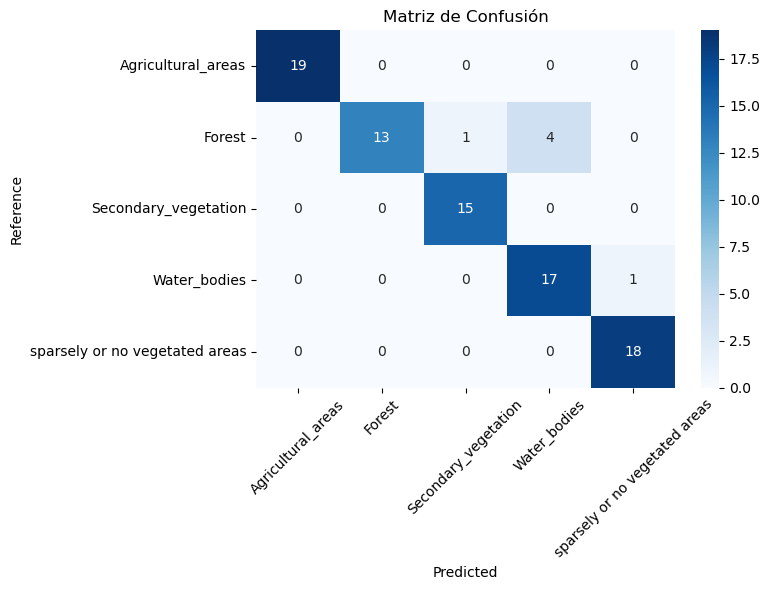

In [42]:
conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted")
plt.ylabel("Reference")
plt.title("Matriz de Confusión")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [43]:
accuracy = accuracy_score(y_true, y_pred)
print(f"\n✅ Exactitud global: {accuracy * 100:.2f}%")


✅ Exactitud global: 93.18%


#### Métricas añadiendo como covariable la clasificación no supervisada

In [ ]:
# Leer la capa
points_gdf = gpd.read_file(vec_file, layer=vec_lyr)

rename_map = {
    1: "Agricultural_areas",
    2: "Forest",
    5: "Water_bodies",
    3: "Secondary_vegetation",
    4: "sparsely or no vegetated areas"
}

# Extraer valores del raster clasificado para cada punto
points_gdf["Classified"] = point_query(points_gdf, "clasificacion_rf_2018_sup.kea", interpolate='nearest')

# Reemplazar los valores en la columna "Reference"
points_gdf["Classified"] = points_gdf["Classified"].replace(rename_map)
# Sobrescribir la misma capa en el mismo archivo
points_gdf.to_file(vec_file, layer=vec_lyr, driver="GPKG")

In [ ]:
# Archivo de salida en GeoJSON
vec_refpts_file = os.path.join(out_pts_dir, "cls_acc_assessment_pts_ref.geojson")
vec_refpts_lyr = "cls_acc_assessment_pts_ref"

# Exportar la capa desde el GPKG a GeoJSON
rsgislib.vectorutils.vector_translate(
    vec_file=vec_file,
    vec_lyr="amazontesting", 
    out_vec_file=vec_refpts_file,
    out_vec_lyr=vec_refpts_lyr,
    out_format="GeoJSON",
    del_exist_vec=True
)

print("Puntos de evaluación exportados a GeoJSON correctamente.")

In [ ]:
out_cls_img = "clasificacion_rf_2018_sup.kea"
rsgislib.classification.pop_class_info_accuracy_pts(
    input_img=out_cls_img,
    vec_file=vec_refpts_file,
    vec_lyr=vec_refpts_lyr,
    rat_class_col="class_names",
    vec_class_col="Classified",
    vec_ref_col=None,
    vec_process_col=None,
)

In [ ]:
vec_refpts_vld_file = os.path.join(out_pts_dir, "cls_acc_assessment_pts_ref_vld.geojson")
vec_refpts_vld_lyr = "cls_acc_assessment_pts_ref_vld"
print(points_gdf )
points_gdf = points_gdf.drop(points_gdf[points_gdf["Classified"] == "NA"].index)
points_gdf.to_file(vec_refpts_vld_file, driver="GeoJSON")

In [ ]:
from rsgislib.classification.classaccuracymetrics import calc_acc_metrics_vecsamples_img


out_json_file = os.path.join(out_stats_dir, "cls_rf_refl_acc_info.json")
out_csv_file = os.path.join(out_stats_dir, "cls_rf_refl_acc_info.csv")

calc_acc_metrics_vecsamples_img(
    vec_file=vec_refpts_vld_file,
    vec_lyr=vec_refpts_vld_lyr,
    ref_col="Reference",
    cls_col="Classified",
    cls_img=out_cls_img,
    img_cls_name_col="class_names",
    img_hist_col="Histogram",
    out_json_file=out_json_file,
    out_csv_file=out_csv_file,
)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar solo los puntos que sí fueron clasificados (evita NaN)
valid_points = points_gdf.dropna(subset=["Classified"])

# Asignar valores reales
y_true = valid_points["Reference"].astype(str)
y_pred = valid_points["Classified"].astype(str)

# 2. Obtener las clases únicas ordenadas (garantiza consistencia en el reporte)
unique_classes = sorted(set(y_true.unique()) | set(y_pred.unique()))

In [ ]:
print("📊 Reporte de clasificación:")
print(classification_report(
    y_true, 
    y_pred, 
    labels=unique_classes,
    target_names=unique_classes,
    digits=3
))

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted")
plt.ylabel("Reference")
plt.title("Matriz de Confusión")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
print(f"\n✅ Exactitud global: {accuracy * 100:.2f}%")